In [110]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
from scipy import stats
import statsmodels.api as sm



from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor


Kjører først tobit der samme latente variabel som bestemmer seleksjon + verdi gitt selektert. Deretter utvider jeg til heckit som modellerer seleksjon separat.

Utvalg:

In [85]:
N = 100
β = np.array([0,1])

x = np.random.uniform(-1,1,size=N)
X = np.c_[np.ones(N), x]
u = np.random.randn(N)

y_latent = X@β + u
y = y_latent*(y_latent > 0)

Populasjon:

In [86]:
N_pop = 10000


x_pop = np.random.uniform(-1,1,size=N_pop)
X_pop = np.c_[np.ones(N_pop), x_pop]
u_pop = np.random.randn(N_pop)

y_latent_pop = X_pop@β + u_pop
y_pop = y_latent_pop*(y_latent_pop > 0)

Kan først kjøre hele utvalget standard.

In [87]:
params = inv(X.T@X)@X.T@y

In [88]:
quadratic = make_pipeline(PolynomialFeatures(2),LinearRegression()).fit(x[:,None],y)
#forest = RandomForestRegressor().fit(x_pop[:,None],y_pop)

No handles with labels found to put in legend.


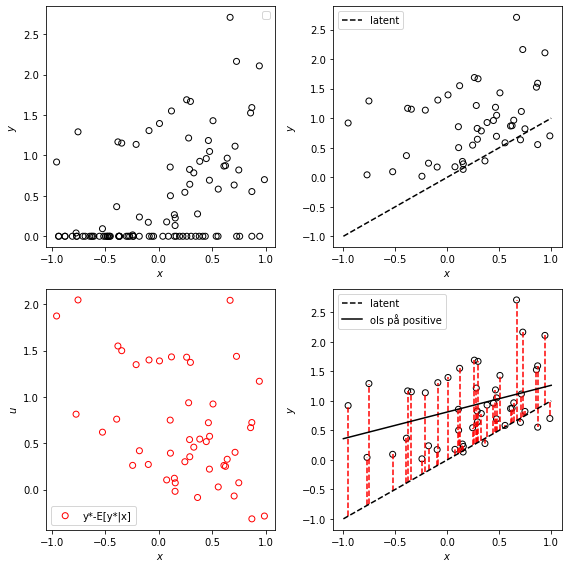

In [102]:
lin_reg = LinearRegression().fit(x[y_latent>0][:,None], y[y_latent >0])
x_grid = np.linspace(-1,1)


fig, axes = plt.subplots(2,2,figsize=(8,8))
axes = axes.flatten()
axes[0].scatter(x,y, facecolor='none', edgecolors='black')
axes[1].scatter(x[y_latent>0],y[y_latent>0],facecolor='none', edgecolors='black')
axes[1].plot(x_grid, x_grid, '--', color='black', label='latent')
axes[2].scatter(x[y_latent>0],u[y_latent>0],facecolor='none', edgecolors='red', label='y*-E[y*|x]')
axes[3].scatter(x[y_latent>0],y[y_latent>0],facecolor='none', edgecolors='black')
axes[3].plot(x_grid, x_grid, '--',color='black', label='latent')
axes[3].vlines(x[y_latent>0], x[y_latent>0], y[y_latent>0], linestyle='dashed', color='red')
axes[3].plot(x_grid, lin_reg.predict(x_grid[:,None]), color='black', label='ols på positive')

for ax in axes:
    ax.set(xlabel='$x$',ylabel='$y$')
    ax.legend()
axes[2].set(ylabel='$u$')
fig.tight_layout()
fig.savefig('tobit1.pdf')

Kan beregne E[y|x]... det er ikke lineær selv om latent er lineær, så kan ikke kjøre vanilje OLS på hele datasett. Hvis målet er prediksjoner så er dette sikkert en grei fremgangsmåte..

ser at det er problem at ikke-parametrisk metode blir veldig ustabil.

Problem med å lære latent fra observert data... kjøre på hele blir dødfødt og hvis jeg betinger på positivt..

### Heckit

Vil prøve en estimering av heckit.. NOTE: HAR IKEK FÅTT TIL :((((

In [141]:
N = 100
x = np.random.uniform(-1,1,N)
z = np.random.uniform(-1,1,N)
errors = np.random.multivariate_normal(np.zeros(2), np.array([[1,.5],[.5,1]]),size=N)
ϵ = errors[:,0]
u = errors[:,1]

y_latent = x + ϵ
s_latent = x + z + u

s = (s_latent > 0).astype(int)
y = y_latent * (s_latent > 0)


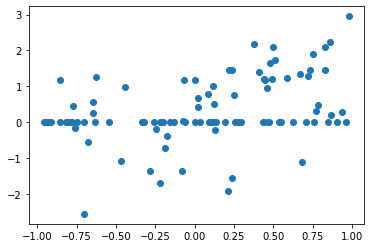

In [142]:
plt.scatter(x,y)

1. Estimere heckmans lambda til hver observasjon... probit for koeff og putt sjitet inn i mills ratio
2. kjør vanlig ols med estimert heckman lambda som variabel

In [143]:
sm.add_constant(np.c_[x,z])

array([[ 1.        , -0.80706763,  0.03268981],
       [ 1.        , -0.9098249 , -0.14286946],
       [ 1.        ,  0.11953577, -0.86493791],
       [ 1.        ,  0.66742607, -0.36252243],
       [ 1.        , -0.67969492,  0.47978555],
       [ 1.        , -0.19991859,  0.64510091],
       [ 1.        , -0.85801869,  0.85029482],
       [ 1.        ,  0.00414127, -0.55280718],
       [ 1.        , -0.62926301, -0.36239533],
       [ 1.        ,  0.23571079,  0.49533097],
       [ 1.        , -0.81778399, -0.04837992],
       [ 1.        , -0.44054457, -0.02400947],
       [ 1.        ,  0.08273752,  0.74188468],
       [ 1.        ,  0.70697721, -0.33308277],
       [ 1.        , -0.28232152,  0.5185529 ],
       [ 1.        , -0.63219788,  0.85293149],
       [ 1.        ,  0.830933  ,  0.91722011],
       [ 1.        ,  0.4410976 ,  0.56626786],
       [ 1.        ,  0.25965386,  0.72614926],
       [ 1.        , -0.94302191,  0.75184696],
       [ 1.        ,  0.12738368, -0.450

In [144]:
c = sm.Probit(s, sm.add_constant(np.c_[x,z])).fit().fittedvalues

Optimization terminated successfully.
         Current function value: 0.583373
         Iterations 5


In [145]:
λ = stats.norm().pdf(s) / stats.norm.cdf(s)

In [146]:
len(s_latent>0)

100

In [147]:
λ

array([0.79788456, 0.79788456, 0.79788456, 0.28759997, 0.28759997,
       0.28759997, 0.28759997, 0.79788456, 0.28759997, 0.28759997,
       0.79788456, 0.28759997, 0.28759997, 0.79788456, 0.28759997,
       0.79788456, 0.28759997, 0.28759997, 0.79788456, 0.79788456,
       0.28759997, 0.79788456, 0.79788456, 0.28759997, 0.79788456,
       0.28759997, 0.79788456, 0.79788456, 0.79788456, 0.79788456,
       0.79788456, 0.79788456, 0.79788456, 0.28759997, 0.28759997,
       0.79788456, 0.28759997, 0.28759997, 0.79788456, 0.28759997,
       0.28759997, 0.28759997, 0.28759997, 0.28759997, 0.79788456,
       0.79788456, 0.79788456, 0.79788456, 0.28759997, 0.79788456,
       0.79788456, 0.79788456, 0.28759997, 0.28759997, 0.79788456,
       0.79788456, 0.79788456, 0.79788456, 0.28759997, 0.28759997,
       0.28759997, 0.28759997, 0.79788456, 0.79788456, 0.79788456,
       0.79788456, 0.28759997, 0.79788456, 0.79788456, 0.28759997,
       0.28759997, 0.28759997, 0.28759997, 0.28759997, 0.79788

In [148]:
np.c_[x[s_latent>0],λ[s_latent>0]]

array([[ 0.66742607,  0.28759997],
       [-0.67969492,  0.28759997],
       [-0.19991859,  0.28759997],
       [-0.85801869,  0.28759997],
       [-0.62926301,  0.28759997],
       [ 0.23571079,  0.28759997],
       [-0.44054457,  0.28759997],
       [ 0.08273752,  0.28759997],
       [-0.28232152,  0.28759997],
       [ 0.830933  ,  0.28759997],
       [ 0.4410976 ,  0.28759997],
       [ 0.12738368,  0.28759997],
       [ 0.21112086,  0.28759997],
       [ 0.58942455,  0.28759997],
       [ 0.45726812,  0.28759997],
       [ 0.00267028,  0.28759997],
       [ 0.476127  ,  0.28759997],
       [ 0.02192413,  0.28759997],
       [ 0.68218072,  0.28759997],
       [ 0.73455451,  0.28759997],
       [ 0.11804087,  0.28759997],
       [ 0.72191197,  0.28759997],
       [ 0.12555637,  0.28759997],
       [ 0.44456649,  0.28759997],
       [ 0.25076838,  0.28759997],
       [ 0.49756818,  0.28759997],
       [-0.64867378,  0.28759997],
       [ 0.37553053,  0.28759997],
       [ 0.7703468 ,

In [131]:
sm.OLS(y[s_latent>0], sm.add_constant(np.c_[x[s_latent>0],λ[s_latent>0]])).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.167
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     994.3
Date:                Sat, 28 Nov 2020   Prob (F-statistic):          4.22e-199
Time:                        16:44:27   Log-Likelihood:                -6801.4
No. Observations:                4972   AIC:                         1.361e+04
Df Residuals:                    4970   BIC:                         1.362e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.7863      0.025     31.532      0.000       0.737       0.835
x2             1.1666      0.051     23.067      0.000       1.067       1.266
==============================================================================
Omnibus:                        1.789   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.409   Jarque-Bera (JB):                1.742
Skew:                           0.043   Prob(JB):                        0.418
Kurtosis:                       3.032   Cond. No.                         2.28
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

ikke kosher men okay...*